In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Matplotlib is building the font cache; this may take a moment.


In [3]:
print("Loading US Accidents dataset...")
# us_accidents = pd.read_csv('/data/US_Accidents_March23.csv')
# print("US Accidents dataset loaded.")
# print(us_accidents.head())
file_path = 'data/US_Accidents_March23.csv'

step = 77

# Use the skiprows parameter to load only the desired rows
# Generate a list of rows to skip
rows_to_skip = [i for i in range(1, 7728394) if i % step != 0]  # Skip all except every 77th row

# Read the CSV with the selected rows
us_accidents = pd.read_csv(file_path, skiprows=rows_to_skip)

# Verify the size of the sample
print(f"Sample size: {len(us_accidents)}")
print(us_accidents.head())



Loading US Accidents dataset...
Sample size: 100369
      ID   Source  Severity           Start_Time             End_Time  \
0   A-77  Source2         3  2016-02-10 07:50:08  2016-02-10 08:20:08   
1  A-154  Source2         2  2016-02-15 08:00:58  2016-02-15 08:30:58   
2  A-231  Source2         2  2016-02-17 12:57:34  2016-02-17 13:27:34   
3  A-308  Source3         3  2016-02-22 07:24:22  2016-02-22 07:54:22   
4  A-385  Source2         2  2016-02-24 11:25:37  2016-02-24 11:55:37   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.954617 -82.844238      NaN      NaN          0.01  ...      False   
1  39.945370 -82.887444      NaN      NaN          0.01  ...      False   
2  39.615208 -84.227318      NaN      NaN          0.01  ...      False   
3  39.933804 -82.789444      NaN      NaN          0.01  ...      False   
4  39.753105 -84.151581      NaN      NaN          0.01  ...      False   

  Station   Stop Traffic_Calming Traffic_Signal Turning_Lo

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100369 entries, 0 to 100368
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     100369 non-null  object 
 1   Source                 100369 non-null  object 
 2   Severity               100369 non-null  int64  
 3   Start_Time             100369 non-null  object 
 4   End_Time               100369 non-null  object 
 5   Start_Lat              100369 non-null  float64
 6   Start_Lng              100369 non-null  float64
 7   End_Lat                56178 non-null   float64
 8   End_Lng                56178 non-null   float64
 9   Distance(mi)           100369 non-null  float64
 10  Description            100369 non-null  object 
 11  Street                 100230 non-null  object 
 12  City                   100365 non-null  object 
 13  County                 100369 non-null  object 
 14  State                 

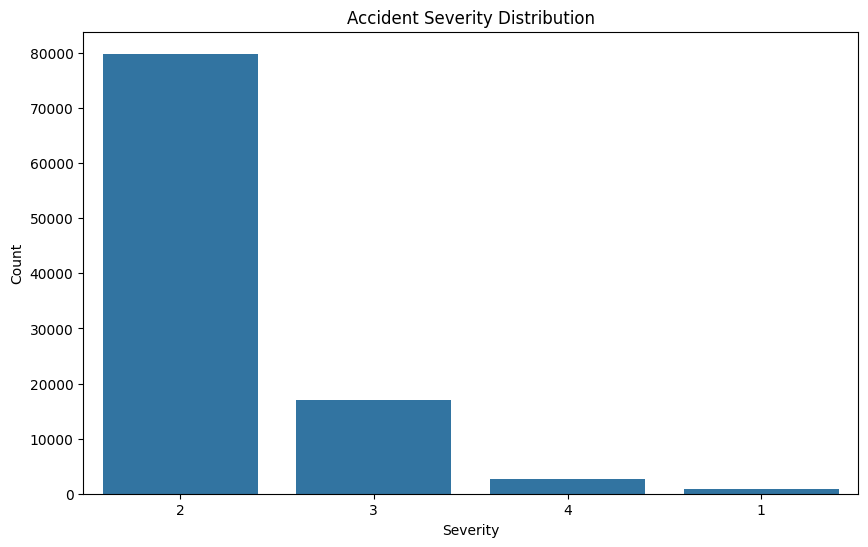

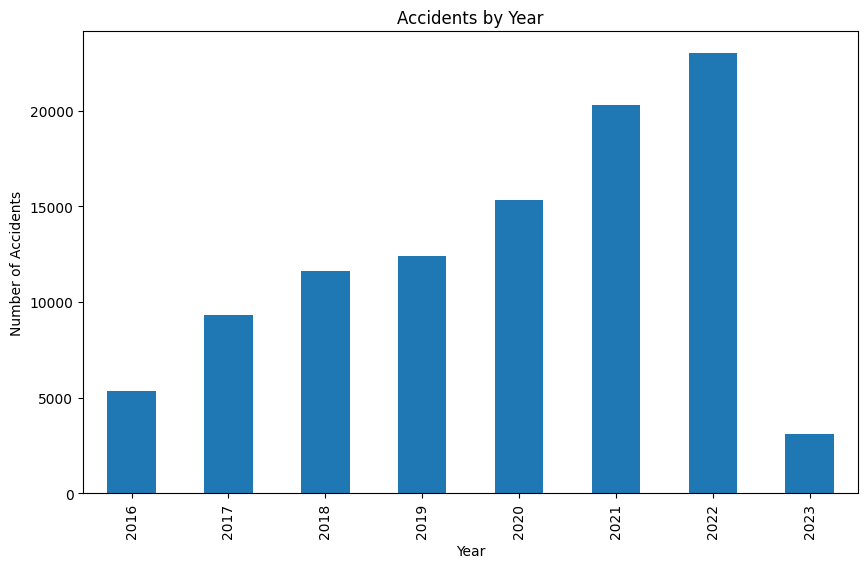

In [4]:
print("Dataset Info:")
us_accidents.info()

print("Performing Exploratory Data Analysis...")
plt.figure(figsize=(10, 6))
sns.countplot(data=us_accidents, x='Severity', order=us_accidents['Severity'].value_counts().index)
plt.title('Accident Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

us_accidents['Start_Time'] = us_accidents['Start_Time'].str.split('.').str[0]
us_accidents['Start_Time'] = pd.to_datetime(us_accidents['Start_Time'].str.split('.').str[0], errors='coerce')
us_accidents['Year'] = us_accidents['Start_Time'].dt.year
plt.figure(figsize=(10, 6))
us_accidents['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.show()


In [5]:
print("Preprocessing the dataset...")
us_accidents = us_accidents.dropna(subset=['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)'])
X = us_accidents[['Start_Lat', 'Start_Lng', 'Distance(mi)']].values
y = us_accidents['Severity'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y - 1, dtype=torch.long)  # Shift labels from 1-4 to 0-3

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(list(zip(X_tensor, y_tensor)), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Preprocessing the dataset...


In [7]:
class AccidentSeverityModel(nn.Module):
    def __init__(self):
        super(AccidentSeverityModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = AccidentSeverityModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training the model...")
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Evaluating the model...")
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

print("Accuracy:", accuracy_score(all_targets, all_preds))
print("Classification Report:")
print(classification_report(all_targets, all_preds))


Training the model...
Epoch 1/5, Loss: 0.6570
Epoch 2/5, Loss: 0.6115
Epoch 3/5, Loss: 0.6030
Epoch 4/5, Loss: 0.5960
Epoch 5/5, Loss: 0.5873
Evaluating the model...
Accuracy: 0.7998904054996513
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       173
           1       0.80      1.00      0.89     16054
           2       0.75      0.00      0.00      3317
           3       0.00      0.00      0.00       530

    accuracy                           0.80     20074
   macro avg       0.39      0.25      0.22     20074
weighted avg       0.76      0.80      0.71     20074



/Users/apple/Desktop/MDST_TAP/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/Desktop/MDST_TAP/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/Desktop/MDST_TAP/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [18]:
print("Loading Traffic Flow dataset...")
traffic_flow_data = loadmat('/data/traffic_dataset.mat')
print("Traffic Flow dataset loaded.")

print("Integrating traffic flow data...")
traffic_X_te = traffic_flow_data['tra_X_te'][0]
traffic_features = np.mean([x.mean(axis=1) for x in traffic_X_te], axis=0)
us_accidents['Traffic_Feature'] = np.random.choice(traffic_features.flatten(), size=us_accidents.shape[0], replace=True)
X = us_accidents[['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Traffic_Feature']].values
y = us_accidents['Severity'].values -1

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(list(zip(X_tensor, y_tensor)), [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = AccidentSeverityModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Retraining the model with integrated data...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Evaluating the integrated model...")
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

print("Integrated Model Accuracy:", accuracy_score(all_targets, all_preds))
print("Classification Report:")
print(classification_report(all_targets, all_preds))

print("Analysis complete.")


Loading Traffic Flow dataset...
Traffic Flow dataset loaded.
Integrating traffic flow data...
Retraining the model with integrated data...
Epoch 1/2, Loss: 0.5564
Epoch 2/2, Loss: 0.5435
Evaluating the integrated model...
Integrated Model Accuracy: 0.7967883370350506
Classification Report:


/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13358
           1       0.80      1.00      0.89   1231371
           2       0.65      0.00      0.00    259940
           3       0.00      0.00      0.00     41010

    accuracy                           0.80   1545679
   macro avg       0.36      0.25      0.22   1545679
weighted avg       0.74      0.80      0.71   1545679

Analysis complete.


/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daehwanyoo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
